In [1]:
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
# For data manipulation
import pandas as pd
import numpy as np
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For prediction
from tqdm import tqdm

from extract_zip import extract_zip_to_memory # function for decompressing zip in memory
from PIL import Image, ImageOps # image handling
from io import BytesIO # image handling

# for the CNN
import keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential

from sklearn import preprocessing

basepath = "/mnt/datasets/plankton/flowcam/"

Using TensorFlow backend.


## Introduction
In this Notebook we explore a computer vision problem. We are tasked with classifying the taxonomy of plankton from images using deep neural networks. Our main approach is based on processing images with a Convolutional Neural Network with Keras. We will compare our approach with classification on carefully (but manually) engineered features pre-computed on each image object.

Throughout the task we will learn and explore common problems in computer vision. We will process images, augment them to increase the amount of data and look at computational cost when doing CNNs. The goal of this task is not to achieve the highest possible accuracy, but rather explore and learn about image classification. 

The data was prepared in cooperation with the Laboratoire d’Océanographie de Villefranche, jointly run by Sorbonne Université and CNRS. Plankton images were acquired in the bay of Villefranche, weekly since 2013 and manually engineered features were computed on each imaged object.

## Summary
Using the manually engineered features in a Random Forest Classifier gave the best result with a F1 Macro Score of 53%. This is significantly better than the performance of the CNN. Still there is a lot of performance to gain in the CNN as we choose options which reduced our computational expenses. Increasing the size of the input to the CNN should give more information to the CNN, which could give a better classification. Inreasing the complexity of the CNN while running more epochs could also increase the score. An architecture like VGG16 have handled similar problems very well. 

We have handled complications like skewness in input data, loosing information in image processing and handling of increasing computational costs. As it was specified in the task that the purpose of this challenge was not to simply find the best-performing model, but to explore the dificulties that come with computer vision, we are content with our results. 

In [2]:
imgFiles = extract_zip_to_memory(basepath + "imgs.zip")

In [3]:
# label dataset
labelsDF = pd.read_csv(basepath + 'meta.csv')

In [4]:
labelsDF['objid'] = labelsDF['objid'].astype(np.int64, errors='ignore')
labelsDF['level1'] = labelsDF['level1'].fillna('No_level1_name')
labelsDF['level2'] = labelsDF['level2'].fillna('No_level2_name')

print(labelsDF.isnull().sum().any())

False


In [5]:
print('Nr. of unique level1 names:', labelsDF['level1'].nunique())
print('Nr. of unique level2 names:', labelsDF['level2'].nunique())
print('Nr. of unique names  total:', labelsDF['unique_name'].nunique())

Nr. of unique level1 names: 57
Nr. of unique level2 names: 40
Nr. of unique names  total: 103


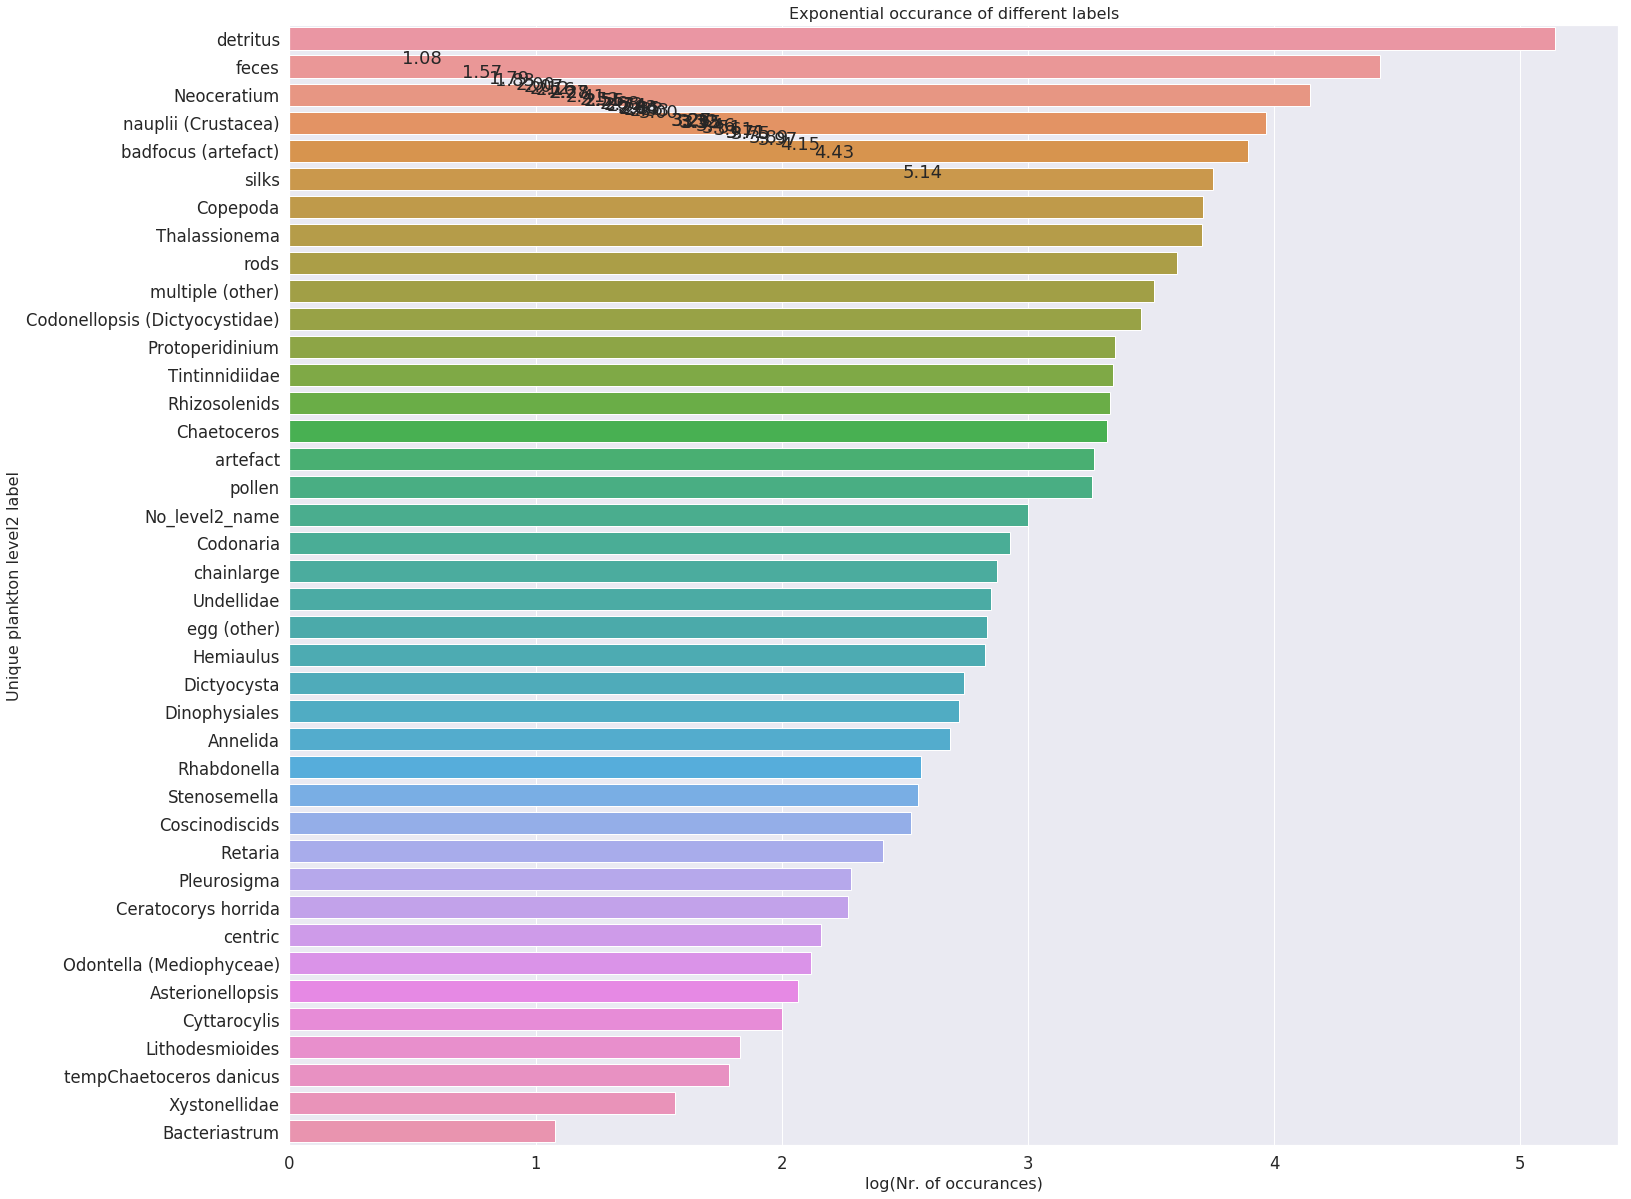

In [6]:
number_unique_names = labelsDF.groupby('level2', as_index=True)['id'].count()
number_unique_names.sort_values(inplace=True, ascending=False)

sns.set(font_scale = 1.5)
figure, ax = plt.subplots(figsize=(23,17))
ax = sns.barplot(y=number_unique_names.index, x=np.log10(number_unique_names.values))
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")



for p in ax.patches:
    ax.annotate(format(p.get_width(),'.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_width()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.ylabel('Unique plankton level2 label', fontsize= 16)
plt.xlabel('log(Nr. of occurances)', fontsize= 16)
plt.title('Exponential occurance of different labels', fontsize=16)
plt.tight_layout()

In [7]:
# Fetching the object ids that pertain to specific labels
# And fetching the level2 labels of the categories we want to duplicate
unique_names = list(number_unique_names.index)
original_objid_dict = {}
labels_to_multiply = []
labels_not_to_multiply = []

for name in unique_names:
    objid_labels = list(labelsDF.loc[labelsDF['level2'] == name, 'objid'])
    original_objid_dict.update({name : objid_labels})
    print('Label:', name[:4], 'has', len(objid_labels), 'object IDs.')
    # Find labels that we want to generate more data within
    if len(objid_labels) < 1000:
        labels_to_multiply.append(name)
    else:
        labels_not_to_multiply.append(name)

Label: detr has 138439 object IDs.
Label: fece has 26936 object IDs.
Label: Neoc has 14014 object IDs.
Label: naup has 9293 object IDs.
Label: badf has 7848 object IDs.
Label: silk has 5629 object IDs.
Label: Cope has 5141 object IDs.
Label: Thal has 5117 object IDs.
Label: rods has 4044 object IDs.
Label: mult has 3261 object IDs.
Label: Codo has 2888 object IDs.
Label: Prot has 2256 object IDs.
Label: Tint has 2227 object IDs.
Label: Rhiz has 2160 object IDs.
Label: Chae has 2105 object IDs.
Label: arte has 1849 object IDs.
Label: poll has 1821 object IDs.
Label: No_l has 1003 object IDs.
Label: Codo has 845 object IDs.
Label: chai has 751 object IDs.
Label: Unde has 710 object IDs.
Label: egg  has 685 object IDs.
Label: Hemi has 670 object IDs.
Label: Dict has 549 object IDs.
Label: Dino has 525 object IDs.
Label: Anne has 481 object IDs.
Label: Rhab has 367 object IDs.
Label: Sten has 357 object IDs.
Label: Cosc has 334 object IDs.
Label: Reta has 257 object IDs.
Label: Pleu has 19

### Functions used for the autoloader and preprocessing

In [8]:
def strip(key):
    return int(key[5:-4])

def key_to_objid(list_of_keys):
    return [strip(key) for key in list_of_keys]

def reverse_strip(objid):
    return 'imgs/' + str(objid) + '.jpg'

def objid_to_key(list_of_objids):
    return [reverse_strip(objid) for objid in list_of_objids]

# Functions to preprocess images
def image_processing(key):
    desired_size = 972 # max of width and height in dataset
    im_orginal = Image.open(imgFiles[key])
    old_size = im_orginal.size  # old_size[0] is in (width, height) format
    
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im_scaled = im_orginal.resize(new_size) # scale up picture before padding to keep information
    
    delta_w = desired_size - new_size[0]
    delta_h = desired_size - new_size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    im_padded = ImageOps.expand(im_scaled, padding, fill=255) # padding of scaled picture
    
    final_size = (40, 40) # input size for CNN
    im_final = im_padded.resize(final_size, resample=0) # resize to input size of CNN
    return np.array(im_final)

def fetch_label(key, lvl='level2'):
    return list(labelsDF[labelsDF['objid']==strip(key)][lvl])[0]

#print(fetch_label('imgs/32627324.jpg'))

In [9]:
img_keys = list(imgFiles.keys())
processed_imgs = {strip(key) : [image_processing(key), fetch_label(key)] for key in tqdm(img_keys)}

100%|██████████| 243610/243610 [07:28<00:00, 543.25it/s]


In [10]:
del imgFiles

In [11]:
def generate_new_object_ids(object_id):
    stripped_key = str(object_id)
    key_lr = int('8' + stripped_key[1:])
    key_ud = int('1' + stripped_key[1:])
    key_90 = int('2' + stripped_key[1:])
    key_180 = int('4' + stripped_key[1:])
    key_270 = int('5' + stripped_key[1:])
    key_t1 = int('6' + stripped_key[1:])
    key_t2 = int('7' + stripped_key[1:])
    return {'lr' : key_lr, 'ud' : key_ud, '90' : key_90, '180' : key_180,
                '270' : key_270, 't1' : key_t1, 't2' : key_t2}

def generate_duplicates_numpy(object_id, image_files=processed_imgs):
    # Fetching and making numpy array of original object
    img_np_array = image_files[object_id][0]

    # Generating copies of data using numpy functions for flipping, rotating and transposing
    img_flipped_ud = np.flip(img_np_array, 0)
    img_flipped_lr = np.flip(img_np_array, 1)
    img_rot_90 = np.rot90(img_np_array, k=1)
    img_rot_180 = np.rot90(img_np_array, k=2)
    img_rot_270 = np.rot90(img_np_array, k=3)
    img_tran_1 = np.transpose(img_np_array)
    img_tran_2 = np.flip(np.transpose(np.flip(img_np_array, 1)), 1)
    
    # Generating new keys
    key_dict = generate_new_object_ids(object_id)
    # Fetching label
    lbl = fetch_label(reverse_strip(object_id))
    # Updating dictionary of images with new data
    image_files.update({key_dict['ud'] : [img_flipped_ud, lbl], key_dict['lr'] : [img_flipped_lr, lbl], 
                      key_dict['90'] : [img_rot_90, lbl], key_dict['180'] : [img_rot_180, lbl], 
                      key_dict['270'] : [img_rot_270, lbl], key_dict['t1'] : [img_tran_1, lbl], 
                      key_dict['t2'] : [img_tran_2, lbl]})
    
    return image_files

# Maybe worth checking out for keras data generation later 
# https://medium.com/@ksusorokina/image-classification-with-convolutional-neural-networks-496815db12a8

In [12]:
# To keep track of total amount of images created
total_nr = 0
# We make a new dictionary to keep track of the augmented data, in relation to the original data
augmented_objid_dict = {}

for label in labels_to_multiply:
    # Fetch object IDs pertaining to one specific label
    object_ids = original_objid_dict[label]
    
    #print('For label:', label[:4], 'we generate', len(object_ids)*8, 'new images')
    total_nr += len(object_ids)*8
    
     # Create a list of the object IDs of the newly created images so we can feed them into augmented_objid_dict
    object_ids_new = []
    
    # Create new data
    for objid in object_ids:
        processed_imgs = generate_duplicates_numpy(objid)
        object_ids_new += (list(generate_new_object_ids(objid).values()))
    
    # Append new object IDs to augmented_objid_dict
    augmented_objid_dict.update({label : object_ids + object_ids_new})
    
for label in labels_not_to_multiply:
    augmented_objid_dict.update({label : original_objid_dict[label]})
print('Total nr of new images produced:', total_nr)
print('new length of images:', len(list(processed_imgs.keys())))

Total nr of new images produced: 60632
new length of images: 296663


### Dividing data into test and training

In [68]:
def train_test_val_split(dict_objids_and_labels):
    train_objids = []
    test_objids = [] 
    val_objids = []
    for label in unique_names: # unique names are all labels in level 2 of labelsDF
        object_ids = dict_objids_and_labels[label]
        number_train = int(len(object_ids)*0.6)
        number_test = int(len(object_ids)*0.2)
        train_objids += object_ids[:number_train]
        test_objids += object_ids[number_train:(number_train + number_test)]
        val_objids += object_ids[(number_train + number_test):]
    return train_objids, test_objids, val_objids

# original_objid_dict
# augmented_objid_dict
train_objids, test_objids, val_objids = train_test_val_split(augmented_objid_dict)

train_objids = random.sample(train_objids, len(train_objids))
test_objids = random.sample(test_objids, len(test_objids))
val_objids = random.sample(val_objids, len(val_objids))

In [60]:
print('Train length: ', len(train_objids))
print('Test length: ', len(test_objids))
print('Val length: ', len(val_objids))
print(len(train_objids) + len(test_objids) + len(val_objids))

Train length:  177980
Test length:  59318
Val length:  59365
296663


In [69]:
# We want to label-encode the different categories so we can one-hot encode them.  
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

def autoloader(list_of_object_ids):
    X = np.array([processed_imgs[object_id][0] for object_id in list_of_object_ids])
    y = np.array([processed_imgs[object_id][1] for object_id in list_of_object_ids])
    
    le = LabelEncoder()
    y = le.fit_transform(y)
    # one-hot encode target column
    y = to_categorical(y)

    # Reshape input data to account for images only being greyscale
    X = X.reshape(len(list_of_object_ids), 40, 40, 1)
    return X, y

# Fetch pictures and labels, corresponding to keys.
# train
X_train, y_train = autoloader(train_objids)
# test
X_test, y_test = autoloader(test_objids)
# val
X_val, y_val = autoloader(val_objids)

In [70]:
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('y_val shape:', y_val.shape)

y_train shape: (177980, 40)
y_test shape: (59318, 40)
y_val shape: (59365, 40)


### Parameters for keras CNN

In [71]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras.backend as K
import tensorflow as tf

# input dimensions
input_shape = (40, 40, 1)
# network parameters 
batch_size = 128
classes = labelsDF.level2.unique()
num_classes = labelsDF.level2.nunique()
epochs = 1 # Further Fine Tuning can be done

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

### Architectures
 
- input -> (conv -> pool)*2 -> fc -> softmax
- input -> (conv -> conv -> pool)*3-4 -> fc -> fc -> softmax

#### To further explore
Data augementation of pictures with rare labels
- https://medium.com/@arindambaidya168/https-medium-com-arindambaidya168-using-keras-imagedatagenerator-b94a87cdefad
- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [75]:
# Keras CNN model
model = Sequential()

# add first  layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add second layer
#model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add third layer
#model.add(BatchNormalization())
#model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
#model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))



# add flatten layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))

# add last layer
model.add(Dense(num_classes, activation='softmax'))

# complile the model and view its architecur
model.compile(loss=keras.losses.categorical_crossentropy,  optimizer="Adam", metrics=['accuracy', f1])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 38, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
__________

In [76]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))

Train on 177980 samples, validate on 59365 samples
Epoch 1/1
177980/177980 [==============================] - 382s 2ms/step - loss: 8.6029 - acc: 0.4662 - f1: 0.0159 - val_loss: 8.6003 - val_acc: 0.4664 - val_f1: 0.0159


In [66]:
#from sklearn.metrics import f1_score
test_predict = model.predict(X_test)
test_f1 = f1(y_test, test_predict)

print("Test F1 Score: ", K.get_value(test_f1))

Test F1 Score:  0.015911154


In [74]:
K.clear_session()